In [84]:
import numpy as np
import model as Net
import os
import scipy.misc as misc
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from PIL import Image
import shutil
import numpy as np
import os
import torch
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, random_split

In [85]:
ImageDir="/TrainVal_Set/Images/"
AnnotationDir="/TrainVal_Set/Annotations/"

MinSize=160  # min width/hight of image
MaxSize=1200 # max width/hight of image
MaxBatchSize=20  # Maximoum number of images per batch h*w*bsize (reduce to prevent oom problems)
MaxPixels=800*800*3.#800*800*3. # Maximoum number of pixel per batch h*w*bsize (reduce to prevent oom problems)
logs_dir= "logs/"# "path to logs directory where trained model and information will be stored"
if not os.path.exists(logs_dir): os.makedirs(logs_dir)
UseGPU = True
NumClasses =1
Learning_Rate=1e-5
learning_rate_decay=0.999999#
Weight_Decay=1e-5# Weight for the weight decay loss function
Net=Net.Net(NumClasses=NumClasses,UseGPU=UseGPU) # Create main resnet image classification brach
Net.AddAttententionLayer()
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate,weight_decay=Weight_Decay)


/Users/Sandhanakrishnan/anaconda3/envs/deepl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Sandhanakrishnan/anaconda3/envs/deepl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
num_epochs =10
device =  torch.device("mps")
criterion = torch.nn.BCEWithLogitsLoss()
Net.to(device)

Net(
  (Net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [109]:
def is_image_file(filename):
    # Check if file is an image
    image_extensions = ['.jpg', '.jpeg', '.png']
    return any(filename.lower().endswith(extension) for extension in image_extensions)
class CustomDataset(Dataset):
    def __init__(self, good_dir, bad_dir, masks_dir, transform=None):
        self.good_dir = good_dir
        self.bad_dir = bad_dir
        self.masks_dir = masks_dir
        self.transform = transform

        self.good_images = [os.path.join(good_dir, img) for img in os.listdir(good_dir) if is_image_file(img)]
        self.bad_images = [os.path.join(bad_dir, img) for img in os.listdir(bad_dir) if is_image_file(img)]
        self.total_images = self.good_images + self.bad_images
        self.labels = [1] * len(self.good_images) + [0] * len(self.bad_images)

    def __len__(self):
        return len(self.total_images)

    def __getitem__(self, idx):
        img_path = self.total_images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        
        # If the image is bad, load its mask
        if label == 0:
            mask_name = 'masks' + os.path.basename(img_path)[3:]
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path)
            mask = self.transform(mask)
            # mask = transforms.ToTensor()(mask)
        else:  # If the image is good, create an empty mask
            mask = torch.zeros_like(image[0]).unsqueeze(0)  # Assumes masks are single-channel


        
        return image, mask, label,img_path

# Define your transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Instantiate your dataset
good_dir = '/Users/Sandhanakrishnan/project_classification/Dataset/good'
bad_dir = '/Users/Sandhanakrishnan/project_classification/Dataset/bad'
masks_dir = '/Users/Sandhanakrishnan/project_classification/Dataset/masks'

dataset = CustomDataset(good_dir=good_dir, bad_dir=bad_dir, masks_dir=masks_dir, transform=transform)
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% for training
val_size = int(0.15 * total_size)   # 15% for validation
test_size = total_size - train_size - val_size  # Remaining 15% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [110]:
bs=32
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [89]:

for epoch in range(num_epochs):
    Net.train()  # Set the model to training mode
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for _, batch in enumerate(train_loader):
        inputs,mask,labels,=batch
        inputs,mask, labels = inputs.to(device),mask.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        labels = labels.unsqueeze(1)
        outputs = Net(inputs,mask)
        # print(outputs.shape,labels.shape)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()/len(batch)
        predictions = outputs > 0
        all_labels.extend(labels.view(-1).cpu().numpy())
        all_predictions.extend(predictions.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    # Log metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, "
          f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
 

Epoch 1/10, Loss: 0.22730952501296994, Accuracy: 0.5458515283842795, Precision: 0.7368421052631579, Recall: 0.5316455696202531, F1: 0.6176470588235294
Epoch 2/10, Loss: 0.18636113901933035, Accuracy: 0.9388646288209607, Precision: 0.9736842105263158, Recall: 0.9367088607594937, F1: 0.9548387096774194
Epoch 3/10, Loss: 0.1528934376935164, Accuracy: 0.9606986899563319, Precision: 0.9627329192546584, Recall: 0.9810126582278481, F1: 0.9717868338557993
Epoch 4/10, Loss: 0.12155676633119583, Accuracy: 0.9868995633187773, Precision: 0.9874213836477987, Recall: 0.9936708860759493, F1: 0.9905362776025236
Epoch 5/10, Loss: 0.09452790891130763, Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1: 1.0
Epoch 6/10, Loss: 0.072272344181935, Accuracy: 0.9956331877729258, Precision: 0.9937106918238994, Recall: 1.0, F1: 0.9968454258675079
Epoch 7/10, Loss: 0.06251488626003265, Accuracy: 0.9912663755458515, Precision: 1.0, Recall: 0.9873417721518988, F1: 0.9936305732484076
Epoch 8/10, Loss: 0.0318245027835170

Predicted: good, True Label: good ('/Users/Sandhanakrishnan/project_classification/Dataset/good/good_0167.png',)
Predicted: bad, True Label: bad ('/Users/Sandhanakrishnan/project_classification/Dataset/bad/bad_0004.png',)
Test Loss: 0.001653699539601803
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Score: 1.0


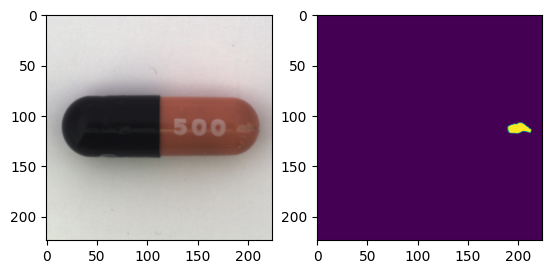

In [121]:
Net.eval()  # Set the model to evaluation mode
running_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for id, batch in enumerate(test_loader):
        inputs, mask, labels,path = batch
        inputs, mask, labels = inputs.to(device), mask.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        # Set mask to zeros_like as in your code
        Mask = torch.zeros_like(mask)
        outputs = Net(inputs, Mask)
        # Convert outputs to binary predictions
        predictions = outputs > 0

        # Append predictions and labels for later metric calculations
        all_labels.extend(labels.view(-1).cpu().numpy())
        all_predictions.extend(predictions.view(-1).cpu().numpy())

        loss = criterion(outputs, labels.float())
        running_loss += loss.item()

        # Optional: print predicted type and true label for each batch
        type = 'good' if predictions.item() > 0 else 'bad'
        true_label = 'good' if labels.item() > 0 else 'bad'
        print(f"Predicted: {type}, True Label: {true_label}",path)
        plt.subplot(121)
        plt.imshow(inputs[0].permute(1, 2, 0).detach().cpu().numpy())
        plt.subplot(122)
        mask_np = mask[0].squeeze(0).detach().cpu().numpy()
        plt.imshow(mask_np)

        # plt.title('Good' if label == 1 else 'Bad')

        if id == 1:
            break

# Calculate metrics
taccuracy = accuracy_score(all_labels, all_predictions)
tprecision = precision_score(all_labels, all_predictions)
trecall = recall_score(all_labels, all_predictions)
tf1 = f1_score(all_labels, all_predictions)

# Print calculated metrics
print(f"Test Loss: {running_loss / len(test_loader)}")
print(f"Accuracy: {taccuracy}, Precision: {tprecision}, Recall: {trecall}, F1 Score: {tf1}")
